In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

# Replace this with the path to your CSV file
file_path = '/content/drive/MyDrive/project/dataset_2186_pbc.arff'

In [69]:
import pandas as pd
from scipy.io import arff

# Load the ARFF file
data, meta = arff.loadarff(file_path)

# Convert to a pandas DataFrame
df = pd.DataFrame(data)

# Display the first few rows
df.head()


,'D',Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Z11,Z12,Z13,Z14,Z15,Z16,Z17,class
0,b'1',b'1',58.7652,b'1',b'1',b'1',b'1',b'1',14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,b'4',400.0
1,b'0',b'1',56.4463,b'1',b'0',b'1',b'1',b'0',1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,b'3',4500.0
2,b'1',b'1',70.0726,b'0',b'0',b'0',b'0',b'0.500000',1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,b'4',1012.0
3,b'1',b'1',54.7406,b'1',b'0',b'1',b'1',b'0.500000',1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,b'4',1925.0
4,b'0',b'2',38.1054,b'1',b'0',b'1',b'1',b'0',3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,b'3',1504.0


In [70]:
df.shape

(418, 19)

In [45]:
first_column = df.iloc[:, 0]
print(first_column)

0      b'1'
1      b'0'
2      b'1'
3      b'1'
4      b'0'
       ... 
413    b'1'
414    b'0'
415    b'0'
416    b'0'
417    b'0'
Name: 'D', Length: 418, dtype: object


In [46]:
df = df.replace('.', pd.NA)  # Replace "." with NA
df['Z3'] = df['Z3'].astype('category')  # Convert 'Z3' (Sex) to categorical
df['D'] = first_column.astype('category')
df.dropna(inplace=True)  # Optionally drop rows with missing data

In [48]:
df.head()

,'D',Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Z11,Z12,Z13,Z14,Z15,Z16,Z17,class,D
0,b'1',b'1',58.7652,b'1',b'1',b'1',b'1',b'1',14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,b'4',400.0,b'1'
1,b'0',b'1',56.4463,b'1',b'0',b'1',b'1',b'0',1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,b'3',4500.0,b'0'
2,b'1',b'1',70.0726,b'0',b'0',b'0',b'0',b'0.500000',1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,b'4',1012.0,b'1'
3,b'1',b'1',54.7406,b'1',b'0',b'1',b'1',b'0.500000',1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,b'4',1925.0,b'1'
4,b'0',b'2',38.1054,b'1',b'0',b'1',b'1',b'0',3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,b'3',1504.0,b'0'


## MCAR

In [5]:
import numpy as np

class MCAR:
    def __init__(self, means, gamma):
        self.arm_means = means
        self.num_arms = len(means)
        self.gamma = gamma
        self.best_arm = np.argmax(means)

    def pull_arm(self, arm):
        reward = np.random.normal(self.arm_means[arm], 1)

        observed = np.random.rand() < self.gamma

        return (reward, observed) if observed else (None, observed)

In [6]:
class MCAR_algo:
    def __init__(self, bandit_env, alpha):
        self.bandit_env = bandit_env
        self.num_arms = bandit_env.num_arms
        self.counts = np.zeros(self.num_arms)
        self.means = np.zeros(self.num_arms)
        self.total_pulls = 0
        self.alpha = alpha

    def select_arm(self, round_number):
        if self.total_pulls < self.num_arms:
            return self.total_pulls

        ucb_values = np.zeros(self.num_arms)
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                ucb_values[arm] = float('inf')
            else:
                confidence_bound = np.sqrt(self.alpha * np.log(round_number) / self.counts[arm])
                ucb_values[arm] = self.means[arm] + confidence_bound

        return np.argmax(ucb_values)

    def update(self, arm, reward, observed):
        if observed:
            self.counts[arm] += 1
            self.means[arm] += (reward - self.means[arm]) / self.counts[arm]

        self.total_pulls += 1

    def update_regret(self, arm, cu_regret, regrets):
        regret = self.bandit_env.arm_means[self.bandit_env.best_arm] - self.bandit_env.arm_means[arm]
        cu_regret += regret
        regrets.append(cu_regret)
        return cu_regret

    def run(self, num_rounds):
        results = []
        regrets = []
        cu_regret = 0
        for round_number in range(num_rounds):
            arm = self.select_arm(round_number)

            reward, observed = self.bandit_env.pull_arm(arm)

            cu_regret = self.update_regret(arm, cu_regret, regrets)
            self.update(arm, reward, observed)

            results.append((arm, reward, observed))

        return results, regrets

In [7]:
# Calculate mean rewards for each arm (Z1)
arm_means = df.groupby('Z1')['class'].mean().values

arm_means /= np.mean(arm_means)

# Step 4: Run the Algorithm
alpha = 1  # Exploration-exploitation trade-off parameter
gamma = 0.8  # Probability of observing the reward
bandit_env = MCAR(arm_means, gamma)

ucb_algo = MCAR_algo(bandit_env, alpha)

# Number of rounds for the simulation
num_rounds = 10000000  # Adjust based on how long you want to run the simulation

# Run the UCB algorithm
results, regrets = ucb_algo.run(num_rounds)

In [27]:
# print(arm_means/np.mean(arm_means))

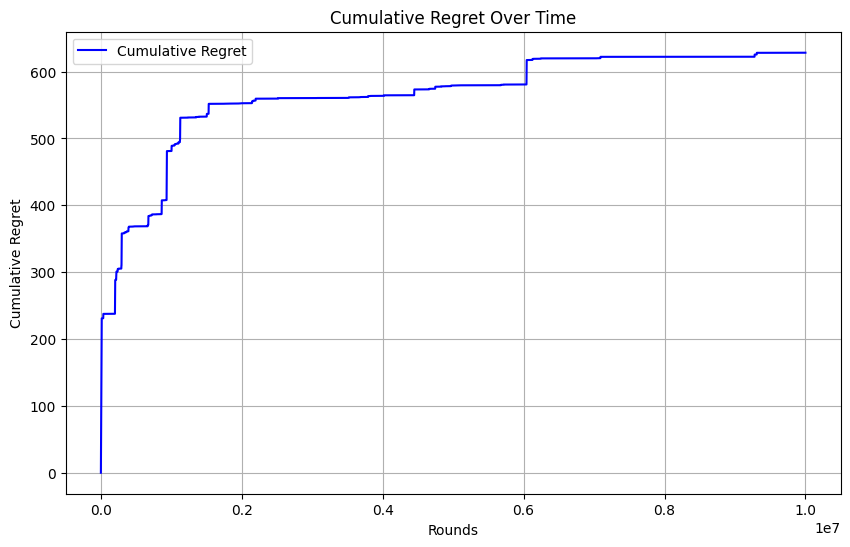

In [8]:
import matplotlib.pyplot as plt

# Plot the cumulative regrets over time
plt.figure(figsize=(10, 6))
plt.plot(regrets, label='Cumulative Regret', color='blue')
plt.title('Cumulative Regret Over Time')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.grid(True)
plt.legend()
plt.show()

## MAR

In [9]:
class UCB_algo:
    def __init__(self, bandit_env, alpha):
        self.bandit_env = bandit_env
        self.num_arms = bandit_env.num_arms
        self.counts = np.zeros(self.num_arms)
        self.means = np.zeros(self.num_arms)
        self.total_pulls = 0
        self.alpha = alpha

    def select_arm(self, round_number):
        if self.total_pulls < self.num_arms:
            return self.total_pulls

        ucb_values = np.zeros(self.num_arms)
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                ucb_values[arm] = float('inf')
            else:
                confidence_bound = np.sqrt(self.alpha / 2 * np.log(self.total_pulls) / self.counts[arm])
                ucb_values[arm] = self.means[arm] + confidence_bound

        return np.argmax(ucb_values)

    def update(self, arm, reward, observed):
        if observed:
            self.counts[arm] += 1
            self.means[arm] += (reward - self.means[arm]) / self.counts[arm]

        self.total_pulls += 1

    def update_regret(self, arm, cu_regret, regrets):
        regret = np.sum(self.bandit_env.p[self.bandit_env.best_arm] * self.bandit_env.means[self.bandit_env.best_arm]) - np.sum(self.bandit_env.p[arm] * self.bandit_env.means[arm])
        cu_regret += regret
        regrets.append(cu_regret)
        return cu_regret

    def run(self, num_rounds):
        results = []
        regrets = []
        cu_regret = 0
        for round_number in range(num_rounds):
            arm = self.select_arm(round_number)

            reward, observed, context = self.bandit_env.pull_arm(arm)

            cu_regret = self.update_regret(arm, cu_regret, regrets)
            self.update(arm, reward, observed)

            results.append((arm, reward, observed))

        return results, regrets

In [10]:
class MAR:
    def __init__(self, means, gamma, prob):
        self.means = means
        self.gamma = gamma
        self.p = prob
        self.num_arms = means.shape[0]  # Number of arms (n)
        self.num_contexts = means.shape[1]  # Number of contexts (k)
        self.best_arm = np.argmax(np.sum(self.p * self.means , axis=1))

    def pull_arm(self, arm):
        if arm >= self.num_arms:
            raise ValueError("Invalid arm index")

        # Select a context based on the probability distribution p[arm]
        context = np.random.choice(self.num_contexts, p=self.p[arm])

        # Reward is drawn from a normal distribution centered at the means[arm, context]
        reward = np.random.normal(self.means[arm, context], 1)

        # Determine if the reward is observed based on the gamma[arm, context]
        observed = np.random.rand() < self.gamma[arm, context]
        if observed:
            return reward, observed, context
        else:
            return None, observed, context

In [11]:
class MAR_algo:
    def __init__(self, bandit_env, alpha, p_known):

        self.bandit_env = bandit_env
        self.num_arms = bandit_env.num_arms
        self.num_contexts = bandit_env.num_contexts
        # self.p = bandit_env.p
        self.alpha = alpha
        self.p_known = p_known
        self.p = np.zeros((self.num_arms, self.num_contexts))

        self.counts = np.zeros((self.num_arms, self.num_contexts))  # Keeps track of how many times each arm-context pair has been pulled
        self.means = np.zeros((self.num_arms, self.num_contexts))  # Estimate of the mean reward for each arm-context pair
        self.s = np.zeros((self.num_arms, self.num_contexts))

    def select_arm(self, round_number):

        # Calculate UCB values for each arm based on all contexts
        ucb_values = np.zeros(self.num_arms)
        for arm in range(self.num_arms):
            if self.p_known:
              self.p = bandit_env.p
            else:
              self.p[arm, :] = self.s[arm, :] / np.sum(self.counts[arm])

            if np.any(self.counts[arm] == 0):
                ucb_values[arm] = float('inf')  # If no context has been explored for this arm, set UCB to infinity
            else:
                # Calculate the mean reward over all contexts weighted by pulls
                mean_reward = np.sum(self.p[arm] * self.means[arm])

                # UCB confidence bound using total counts
                if self.p_known:
                  confidence_bound = np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))
                else:
                  confidence_bound = 8 * np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))
                ucb_values[arm] = mean_reward + confidence_bound

        # Select the arm with the highest UCB value
        return np.argmax(ucb_values)

    def update(self, arm, context, reward, observed):
        self.s[arm, context] += 1

        if observed:
            # Increment the count for the pulled arm-context pair
            self.counts[arm, context] += 1

            # Update the estimated mean reward for this arm-context pair
            self.means[arm, context] = (reward + self.means[arm, context] * (self.counts[arm, context] - 1)) / self.counts[arm, context]

    def update_regret(self, arm, context, cu_regret, regrets):

        regret = np.sum(self.bandit_env.p[self.bandit_env.best_arm] * self.bandit_env.means[self.bandit_env.best_arm]) - np.sum(self.bandit_env.p[arm] * self.bandit_env.means[arm])

        cu_regret += regret  # Add this round's regret to the cumulative regret
        regrets.append(cu_regret)  # Store the cumulative regret
        return cu_regret

    def run(self, num_rounds):

        results = []
        regrets = []
        cu_regret = 0

        for arm in range(self.num_arms):
          for _ in range(int(np.log(num_rounds)**2)):
            reward, observed, context = self.bandit_env.pull_arm(arm)
            cu_regret = self.update_regret(arm, context, cu_regret, regrets)
            self.update(arm, context, reward, observed)
            results.append((arm, reward, observed, context))

        for round_number in range(num_rounds - self.num_arms * int(np.log(num_rounds)**2)):
            # Select an arm using the UCB strategy
            arm = self.select_arm(round_number)

            # Pull the arm and observe the reward and context
            reward, observed, context = self.bandit_env.pull_arm(arm)

            # Update the cumulative regret and store the result
            cu_regret = self.update_regret(arm, context, cu_regret, regrets)

            # Update the means and counts based on the observed reward
            self.update(arm, context, reward, observed)

            # Store the results for this round
            results.append((arm, reward, observed, context))

        return results, regrets

In [28]:
import pandas as pd

k=5

# Step 1: Discretize the Z8 (mediator) into 5 intervals
df['Z8_interval'] = pd.cut(df['Z8'], bins=k, labels=False)  # You can also add labels=True for actual intervals

# Step 2: Group by Z1 (arm) and Z8_interval and calculate the mean reward (class)
grouped = df.groupby(['Z1', 'Z8_interval'])['class'].mean().unstack()

# Step 3: Display the matrix of arm × intervals
print(grouped)

Z8_interval            0            1      2           3       4
Z1                                                              
b'1'         2125.547826  1222.230769  695.2  800.666667     NaN
b'2'         2226.384615   993.454545  864.0  575.750000  717.75


In [29]:
import pandas as pd

# Step 1: Discretize the Z8 (mediator) into 5 intervals
df['Z8_interval'] = pd.cut(df['Z8'], bins=k, labels=False)

# Step 2: Group by Z1 (arm) and Z8_interval and calculate the mean reward (class)
mean_reward_matrix = df.groupby(['Z1', 'Z8_interval'])['class'].mean().unstack()

# Step 3: Replace NaN values with 0
mean_reward_matrix.fillna(0, inplace=True)

# Step 4: Construct the probability matrix
# Normalize each row by dividing by the row sum (sum of rewards per arm)
probability_matrix = mean_reward_matrix.div(mean_reward_matrix.sum(axis=1), axis=0)

# Step 5: Replace any NaN resulting from 0/0 divisions with 0 (if rows sum to 0)
probability_matrix.fillna(0, inplace=True)

# Step 6: Display the final probability matrix
print(probability_matrix)

Z8_interval         0         1         2         3         4
Z1                                                           
b'1'         0.438832  0.252337  0.143528  0.165302  0.000000
b'2'         0.414031  0.184748  0.160674  0.107070  0.133477


In [30]:
n = 2
k = 5

np.random.seed(5)

gamma = np.random.uniform(0.7, 1.0, size=(n, k))

# Randomly generate a probability matrix for the categorical distribution (each row sums to 1)
p = probability_matrix.to_numpy()
means = mean_reward_matrix.to_numpy()

print(p)
print(means)

bandit_env = MAR(means, gamma, p)

alpha = 1
p_known = 1
algo = MAR_algo(bandit_env, alpha, p_known)

[[0.43883227 0.25233697 0.14352826 0.1653025  0.        ]
 [0.41403091 0.18474835 0.16067426 0.10706968 0.1334768 ]]
[[2125.54782609 1222.23076923  695.2         800.66666667    0.        ]
 [2226.38461538  993.45454545  864.          575.75        717.75      ]]


In [31]:
np.random.seed(42)
T = 1000
results, regrets1 = algo.run(T)

<ipython-input-11-1b3319606638>:34: RuntimeWarning: divide by zero encountered in log
  confidence_bound = np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))
<ipython-input-11-1b3319606638>:34: RuntimeWarning: invalid value encountered in sqrt
  confidence_bound = np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))


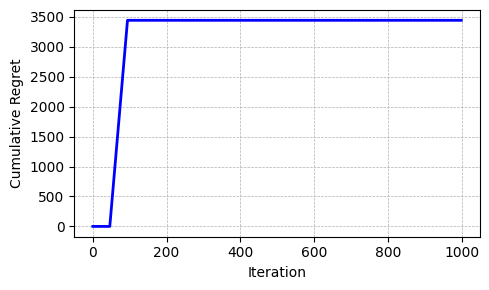

In [32]:
plt.figure(figsize=(5, 3))
plt.plot(regrets1, label='Cumulative Regret', color='blue', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Cumulative Regret')
# plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust the ticks for better readability
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

# Save the figure with high resolution
plt.tight_layout()
plt.savefig('cumulative_regret_plot_paper.png', dpi=300)

# Display the plot
plt.show()

In [33]:
np.random.seed(42)

algo = UCB_algo(bandit_env, alpha)
results, regrets2 = algo.run(1000)

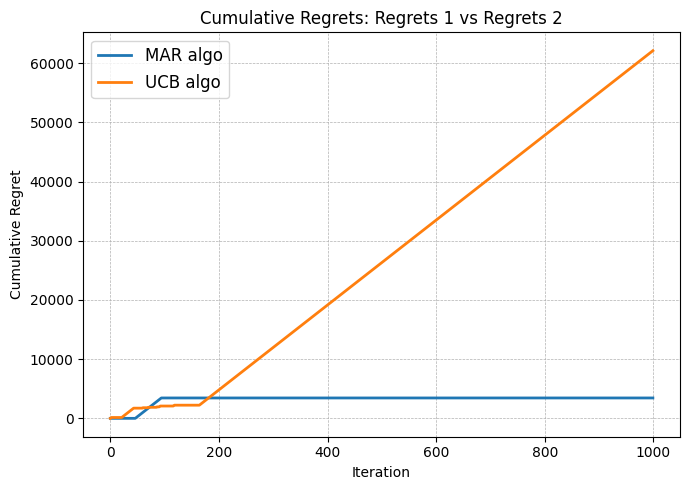

In [34]:
# Plot the regrets on the same figure
plt.figure(figsize=(7, 5))

# Plot regrets1
plt.plot(regrets1, label='MAR algo', linewidth=2)

# Plot regrets2
plt.plot(regrets2, label='UCB algo', linewidth=2)

# Plot settings
plt.xlabel('Iteration')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regrets: Regrets 1 vs Regrets 2')
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save and display the plot
plt.tight_layout()
plt.savefig('regrets1_vs_regrets2.png', dpi=300)
plt.show()

<ipython-input-11-1b3319606638>:34: RuntimeWarning: divide by zero encountered in log
  confidence_bound = np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))
<ipython-input-11-1b3319606638>:34: RuntimeWarning: invalid value encountered in sqrt
  confidence_bound = np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))


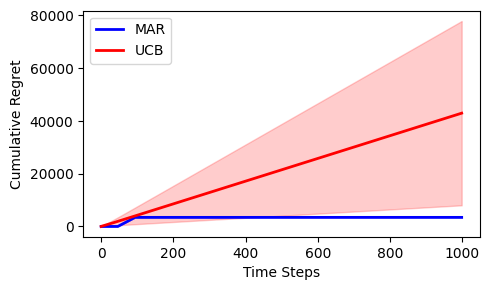

In [35]:
num_repeats = 20  # Number of repetitions to average over

# Initialize arrays to store the cumulative regrets
regrets1_avg = np.zeros(T)
regrets2_avg = np.zeros(T)
regrets1_all = np.zeros((num_repeats, T))
regrets2_all = np.zeros((num_repeats, T))

# Loop over the number of repeats
for i in range(num_repeats):
    # MAR Algorithm
    algo1 = MAR_algo(bandit_env, alpha, p_known)
    _, regrets1 = algo1.run(T)
    regrets1_avg += regrets1
    regrets1_all[i] = regrets1

    # UCB Algorithm
    algo2 = UCB_algo(bandit_env, alpha)
    _, regrets2 = algo2.run(T)
    regrets2_avg += regrets2
    regrets2_all[i] = regrets2

# Average the regrets over the number of repetitions
regrets1_avg /= num_repeats
regrets2_avg /= num_repeats

# Calculate standard deviation for error shading
std_regrets1 = np.std(regrets1_all, axis=0)
std_regrets2 = np.std(regrets2_all, axis=0)

# Plot the averaged regrets with error shading
plt.figure(figsize=(5, 3))

# Plot MAR Algorithm cumulative regret
plt.plot(regrets1_avg, label=r'MAR', color='blue', linewidth=2)
plt.fill_between(np.arange(T), regrets1_avg - std_regrets1, regrets1_avg + std_regrets1, color='blue', alpha=0.2)

# Plot UCB Algorithm cumulative regret
plt.plot(regrets2_avg, label=r'UCB', color='red', linewidth=2)
plt.fill_between(np.arange(T), regrets2_avg - std_regrets2, regrets2_avg + std_regrets2, color='red', alpha=0.2)

# Labeling and formatting
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')

# LaTeX formatted legend
plt.legend(loc='upper left')

# Grid and layout
plt.grid(False)
plt.tight_layout()

# Save and display the plot
plt.savefig('cumulative_regret_MAR_vs_UCB.png', dpi=300)
plt.show()

In [50]:
df.head()

,'D',Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Z11,Z12,Z13,Z14,Z15,Z16,Z17,class,D
0,b'1',b'1',58.7652,b'1',b'1',b'1',b'1',b'1',14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,b'4',400.0,1
1,b'0',b'1',56.4463,b'1',b'0',b'1',b'1',b'0',1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,b'3',4500.0,0
2,b'1',b'1',70.0726,b'0',b'0',b'0',b'0',b'0.500000',1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,b'4',1012.0,1
3,b'1',b'1',54.7406,b'1',b'0',b'1',b'1',b'0.500000',1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,b'4',1925.0,1
4,b'0',b'2',38.1054,b'1',b'0',b'1',b'1',b'0',3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,b'3',1504.0,0


<ipython-input-49-e05bc55fa7d9>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_reward_matrix = df.groupby(['Z1', 'D'])['class'].mean().unstack()
<ipython-input-11-1b3319606638>:34: RuntimeWarning: divide by zero encountered in log
  confidence_bound = np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))
<ipython-input-11-1b3319606638>:34: RuntimeWarning: invalid value encountered in sqrt
  confidence_bound = np.sqrt(self.alpha / 2 * np.log(round_number) * np.sum((p[arm] ** 2) / self.counts[arm]))


Probability Matrix:
D            0         1
Z1                      
b'1'  0.598865  0.401135
b'2'  0.607951  0.392049
Mean Reward Matrix:
D               0            1
Z1                            
b'1'  2271.759494  1521.684211
b'2'  2317.813953  1494.685185

Gamma Matrix:
[[0.76659795 0.96121969]
 [0.76201575 0.97558327]]

Probability Matrix (p):
[[0.59886469 0.40113531]
 [0.60795134 0.39204866]]

Means Matrix:
[[2271.75949367 1521.68421053]
 [2317.81395349 1494.68518519]]


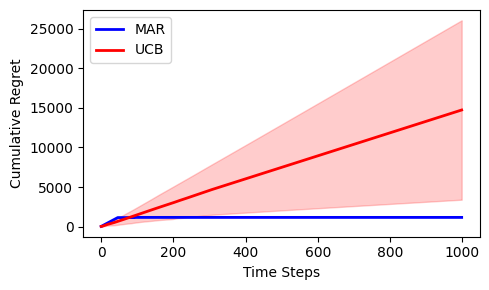

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Convert byte strings in 'D' to integers (0 and 1)
df['D'] = df['D'].apply(lambda x: int(x.decode('utf-8')))  # Convert b'1' and b'0' to integers 1 and 0

# Step 2: Group by 'Z1' (arm) and 'D' (now binary 0 or 1), and calculate the mean reward ('class')
mean_reward_matrix = df.groupby(['Z1', 'D'])['class'].mean().unstack()

# # Step 3: Replace NaN values with 0 (if any)
# mean_reward_matrix.fillna(0, inplace=True)

# Step 4: Construct the probability matrix
# Normalize each row by dividing by the row sum (sum of rewards per arm)
probability_matrix = mean_reward_matrix.div(mean_reward_matrix.sum(axis=1), axis=0)

# # Step 5: Replace any NaN resulting from 0/0 divisions with 0 (if rows sum to 0)
# probability_matrix.fillna(0, inplace=True)

# Step 6: Display the final probability matrix and mean reward matrix
print("Probability Matrix:")
print(probability_matrix)

print("Mean Reward Matrix:")
print(mean_reward_matrix)

# Step 7: Set the number of arms and binary values (n = number of arms, k = 2 since D is binary)
n = mean_reward_matrix.shape[0]  # Number of arms
k = mean_reward_matrix.shape[1]  # Number of binary values (0 and 1)

# Step 8: Generate random gamma values for each arm and binary value
np.random.seed(5)
gamma = np.random.uniform(0.7, 1.0, size=(n, k))

# Convert matrices to numpy arrays for use in the bandit environment
p = probability_matrix.to_numpy()
means = mean_reward_matrix.to_numpy()

print("\nGamma Matrix:")
print(gamma)

print("\nProbability Matrix (p):")
print(p)

print("\nMeans Matrix:")
print(means)

# Example Bandit Environment initialization (replace with your actual environment)
bandit_env = MAR(means, gamma, p)

alpha = 1  # Exploration-exploitation parameter
p_known = 1
T = 1000  # Number of time steps

num_repeats = 20  # Number of repetitions to average over

# Initialize arrays to store the cumulative regrets
regrets1_avg = np.zeros(T)
regrets2_avg = np.zeros(T)
regrets1_all = np.zeros((num_repeats, T))
regrets2_all = np.zeros((num_repeats, T))

# Loop over the number of repeats
for i in range(num_repeats):
    # MAR Algorithm
    algo1 = MAR_algo(bandit_env, alpha, p_known)
    _, regrets1 = algo1.run(T)
    regrets1_avg += regrets1
    regrets1_all[i] = regrets1

    # UCB Algorithm
    algo2 = UCB_algo(bandit_env, alpha)
    _, regrets2 = algo2.run(T)
    regrets2_avg += regrets2
    regrets2_all[i] = regrets2

# Average the regrets over the number of repetitions
regrets1_avg /= num_repeats
regrets2_avg /= num_repeats

# Calculate standard deviation for error shading
std_regrets1 = np.std(regrets1_all, axis=0)
std_regrets2 = np.std(regrets2_all, axis=0)

# Step 10: Plot the averaged regrets with error shading
plt.figure(figsize=(5, 3))

# Plot MAR Algorithm cumulative regret
plt.plot(regrets1_avg, label=r'MAR', color='blue', linewidth=2)
plt.fill_between(np.arange(T), regrets1_avg - std_regrets1, regrets1_avg + std_regrets1, color='blue', alpha=0.2)

# Plot UCB Algorithm cumulative regret
plt.plot(regrets2_avg, label=r'UCB', color='red', linewidth=2)
plt.fill_between(np.arange(T), regrets2_avg - std_regrets2, regrets2_avg + std_regrets2, color='red', alpha=0.2)

# Labeling and formatting
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Regret')

# LaTeX formatted legend
plt.legend(loc='upper left')

# Grid and layout
plt.grid(False)
plt.tight_layout()

# Save and display the plot
plt.savefig('cumulative_regret_MAR_vs_UCB.png', dpi=300)
plt.show()


## MNAR

In [37]:
import numpy as np
import matplotlib.pyplot as plt

class MNAR:
    def __init__(self, means, gamma, prob, rewards):
        self.means = means
        self.gamma = gamma
        self.p = prob
        self.num_arms = means.shape[0]  # Number of arms (n)
        self.num_contexts = means.shape[1]  # Number of contexts (k)
        self.num_reward = means.shape[1]
        self.rewards = rewards
        self.mu = np.zeros((self.num_arms))
        self.best_arm = -1
        self.best_mu = -1

        for a in range(self.num_arms):
          mu = 0
          for m in range(self.num_contexts):
            for y in range(self.num_reward):
              mu += self.p[a, m] * self.means[a, m, y] * self.rewards[y]

          self.mu[a] = mu
          if mu > self.best_mu:
            self.best_mu = mu
            self.best_arm = a

        self.A_matrix = np.zeros((self.num_arms, self.num_contexts, self.num_reward))
        for a in range(self.num_arms):
          for m in range(self.num_contexts):
            for y in range(self.num_reward):
              self.A_matrix[a, m, y] = prob[a, m] * means[a, m, y] * gamma[a, y]
        self.k_A = [np.linalg.cond(self.A_matrix[a]) for a in range(self.num_arms)]

    def pull_arm(self, arm):
        if arm >= self.num_arms:
            raise ValueError("Invalid arm index")

        # Select a context based on the probability distribution p[arm]
        context = int(np.random.choice(self.num_contexts, p=self.p[arm]))

        # Reward is drawn from a normal distribution centered at the means[arm, context]
        reward_i = np.random.choice([i for i in range(self.num_reward)], p=list(self.means[arm, context]))
        reward = self.rewards[reward_i]

        # Determine if the reward is observed based on the gamma[arm, context]
        observed = np.random.rand() < self.gamma[arm, reward_i]
        if observed:
            return reward_i, reward, observed, context
        else:
            return None, None, observed, context

In [38]:
class MNAR_algo:
    def __init__(self, bandit_env):

        self.bandit_env = bandit_env
        self.num_arms = bandit_env.num_arms
        self.num_contexts = bandit_env.num_contexts
        self.num_rewards = bandit_env.num_reward
        self.k_A = bandit_env.k_A
        self.rewards_value = bandit_env.rewards

        self.m0_matrix = np.zeros((bandit_env.num_arms, bandit_env.num_contexts))
        self.my1_matrix = np.zeros((bandit_env.num_arms, bandit_env.num_contexts, bandit_env.num_reward))
        self.my_given_1_matrix = np.zeros((bandit_env.num_arms, bandit_env.num_contexts, bandit_env.num_reward))

        self.T_a = np.zeros(bandit_env.num_arms)
        self.n_a = np.zeros(bandit_env.num_arms)


    def select_arm(self, round_number):
        ucb_values = np.zeros(self.num_arms)
        means = np.zeros(self.num_arms)
        for arm in range(self.num_arms):
          m0_vector = self.m0_matrix[arm]/self.T_a[arm] # K * 1
          my1_matrix = self.my1_matrix[arm]/self.T_a[arm] # K * L
          my_given_1_matrix = self.my_given_1_matrix[arm]/self.n_a[arm] # K * L
          #################
          if np.linalg.det(my1_matrix) == 0:
            ucb_values[arm] = float('inf')
            means[arm] = float('inf')
          else:
            inverse_mymatrix = np.linalg.inv(my1_matrix)
            OR_vector = inverse_mymatrix @ m0_vector
            Ov_gamma_vector = OR_vector + 1 # L * 1
            my_a_matrx = np.zeros((bandit_env.num_contexts, bandit_env.num_reward))
            for i in range(bandit_env.num_contexts):
              for j in range(bandit_env.num_reward):
                my_a_matrx[i, j] = my_given_1_matrix[i, j] * Ov_gamma_vector[j]

            y_a_vector = np.zeros((bandit_env.num_reward))
            for j in range(bandit_env.num_reward):
              for i in range(bandit_env.num_contexts):
                y_a_vector[j] += my_a_matrx[i, j]

            mean = sum(y_a_vector * self.rewards_value)

            cb1 = (self.k_A[arm] / np.linalg.norm(my1_matrix, ord=np.inf)) * np.sqrt(np.log(round_number) / (2 * self.T_a[arm]))
            cb2 = self.num_contexts * np.sqrt(np.log(round_number) / (2 * self.n_a[arm]))

            cb = cb1 + cb2
            means[arm] = mean
            ucb_values[arm] = mean + 100 * cb

        arm = np.argmax(ucb_values)

        return arm, means[arm], ucb_values[arm]

    def update(self, arm, context, reward_i, reward, observed):
        int_obs = 1 if observed else 0
        self.T_a[arm] += 1
        self.n_a[arm] += int_obs
        if observed:
          self.m0_matrix[arm, context] += 1
          self.my1_matrix[arm, context, reward_i] += 1
          self.my_given_1_matrix[arm, context, reward_i] += 1

    def update_regret(self, arm, context, cu_regret, regrets):
        regret = self.bandit_env.mu[self.bandit_env.best_arm] - self.bandit_env.mu[arm]

        cu_regret += regret  # Add this round's regret to the cumulative regret
        regrets.append(cu_regret)  # Store the cumulative regret
        return cu_regret

    def run(self, num_rounds):

        results = []
        regrets = []
        cu_regret = 0

        for arm in range(self.num_arms):
          for _ in range(100):
            reward_i, reward, observed, context = self.bandit_env.pull_arm(arm)
            cu_regret = self.update_regret(arm, context, cu_regret, regrets)
            self.update(arm, context, reward_i, reward, observed)

        for round_number in range(num_rounds - (100 * self.num_arms)):
            # Select an arm using the UCB strategy
            arm, mean, ucb = self.select_arm(round_number)

            # Pull the arm and observe the reward and context
            reward_i, reward, observed, context = self.bandit_env.pull_arm(arm)

            # Update the cumulative regret and store the result
            cu_regret = self.update_regret(arm, context, cu_regret, regrets)

            # Update the means and counts based on the observed reward
            self.update(arm, context, reward_i, reward, observed)

            # Store the results for this round
            results.append((arm, mean, ucb, reward, observed, context))

        return results, regrets